# Environment Setup

In [1]:
def install_packages():
    """
    Install or upgrade the following packages using pip:
    - pip: Package manager for Python.
    - numpy: Library for numerical computing.
    - pandas: Library for data manipulation and analysis.
    - tensorflow: Framework for machine learning and deep learning.
    - scikit-learn: Library for machine learning algorithms.
    - matplotlib: Library for data visualization.
    - seaborn: Library for statistical data visualization.
    - plotly: Library for interactive plotting and visualization.

    Example:
    >>> install_packages()
    """

    %pip install --upgrade pip
    %pip install numpy
    %pip install pandas
    %pip install tensorflow
    %pip install -U scikit-learn
    %pip install -U matplotlib
    %pip install seaborn
    %pip install plotly

    pass

#install_packages()

In [2]:
# Libraries for data manipulation and analysis
import numpy as np
import pandas as pd

# Libraries for machine learning
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Evaluation metrics for regression models

# Libraries for data visualization
import seaborn as sns

# Data Inspection

In [3]:
# Import data
df = pd.read_csv('selected_coastal.csv')

# Drop rows with missing values from the DataFrame
df = df.dropna()
df.head()

,ID,Storm,Lat,Lon,DistancetoCoast,NumberofHouses,TotalValue_2023,Stories_sum,Stories_median,Elevation,Rainfall_Max,Rainfall_Mean,MaxWind,FloodDepth,Damage,DamageRate
6,20,Henri,40.670,-73.985,0.514557,529,1.223136e+09,1552,3.0,15.217467,19.372613,1.459649,30.238714,0.036165,339.0,2.770000e-07
79,632,Henri,40.591,-73.986,0.647500,406,4.500709e+08,877,2.0,2.572017,19.337048,1.743235,21.807135,0.676823,6961.0,1.550000e-05
101,774,Henri,40.642,-73.886,0.121984,700,3.238386e+08,1171,1.0,2.346287,19.856623,1.791890,37.053437,0.222726,1501.0,4.640000e-06
111,829,Henri,40.578,-73.964,0.502252,633,4.358320e+08,2538,2.0,2.536751,19.789047,1.826365,22.210991,0.201621,5899.0,1.350000e-05
125,880,Henri,40.530,-74.176,0.772571,2160,2.186988e+09,2788,2.0,14.402827,19.446697,1.582410,9.769062,0.161686,9309.0,4.260000e-06


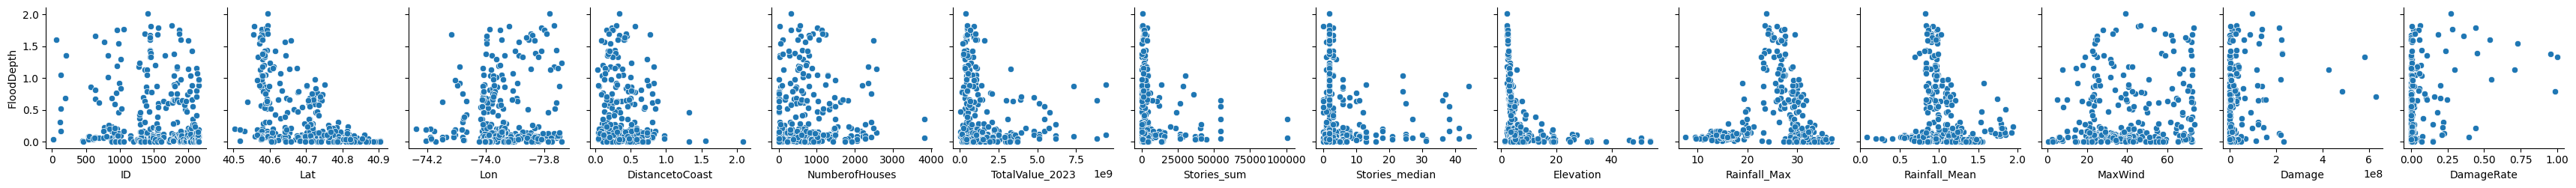

In [4]:
# Create a pairwise scatter plot matrix
sns.pairplot(
    df,
    x_vars=df.drop(columns=['Storm','FloodDepth']).columns,
    y_vars=["FloodDepth"]
)

## Observations
1. Our data is structured (a csv)
2. The goal is a regression: predicting FloodDepth (continuous variable)
3. FloodDepth has a non-linear relationship with the other features

# Neural Network

## Version 1 (DamageRate Only)

In [5]:
# Import a custom module named 'model_utils'
import model_utils as util  

# Extract the 'DamageRate' and reshape it to a 2D array
X = df['DamageRate'].values.reshape(-1, 1)  

# Target/Dependent variable
y = df["FloodDepth"] 

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

# Build and compile the neural network model
model1 = util.build_and_compile_model(x_train)
model1.summary()  # Display the model architecture

# Train the model
history1 = model1.fit(
    x_train, y_train,  # Training data
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=0,  # Suppress verbose output
    epochs=100  # Number of training epochs
)

# Print the final Mean Squared Error after training
print('Mean Squared Error:', history1.history['loss'][-1])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ ?                      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (16.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3 (16.00 B)

Mean Squared Error: 0.17818422615528107


KeyError: 'accuracy'

## Version 2 (All Features)

In [ ]:
# Perform one-hot encoding on the 'Storm' column, creating binary columns for each unique storm
one_hot_encoded = pd.get_dummies(df['Storm'], prefix='storm')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)

# Drop the original 'Storm' column as it's no longer needed after one-hot encoding
df = df.drop(columns=['Storm'])

# Display the first few rows of the DataFrame to verify the transformation
df.head()


,ID,Lat,Lon,DistancetoCoast,NumberofHouses,TotalValue_2023,Stories_sum,Stories_median,Elevation,Rainfall_Max,Rainfall_Mean,MaxWind,FloodDepth,Damage,DamageRate,storm_Henri,storm_Ida,storm_Irene,storm_Isaias,storm_Sandy
6,20,40.670,-73.985,0.514557,529,1.223136e+09,1552,3.0,15.217467,19.372613,1.459649,30.238714,0.036165,339.0,2.770000e-07,1,0,0,0,0
79,632,40.591,-73.986,0.647500,406,4.500709e+08,877,2.0,2.572017,19.337048,1.743235,21.807135,0.676823,6961.0,1.550000e-05,1,0,0,0,0
101,774,40.642,-73.886,0.121984,700,3.238386e+08,1171,1.0,2.346287,19.856623,1.791890,37.053437,0.222726,1501.0,4.640000e-06,1,0,0,0,0
111,829,40.578,-73.964,0.502252,633,4.358320e+08,2538,2.0,2.536751,19.789047,1.826365,22.210991,0.201621,5899.0,1.350000e-05,1,0,0,0,0
125,880,40.530,-74.176,0.772571,2160,2.186988e+09,2788,2.0,14.402827,19.446697,1.582410,9.769062,0.161686,9309.0,4.260000e-06,1,0,0,0,0


In [ ]:
# Extract all independent features 
X = df.drop(columns=["FloodDepth"])

# Target/Dependent variable
y = df["FloodDepth"]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

# Build and compile the neural network model
model2 = util.build_and_compile_model(x_train)
model2.summary() # Display the model architecture

# Train the model
history2 = model2.fit(
    x_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

# Print the final Mean Squared Error after training
print('Mean Squared Error:', history2.history['loss'][-1])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ ?                      │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39 (160.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 39 (160.00 B)

Mean Squared Error: 0.0021870785858482122


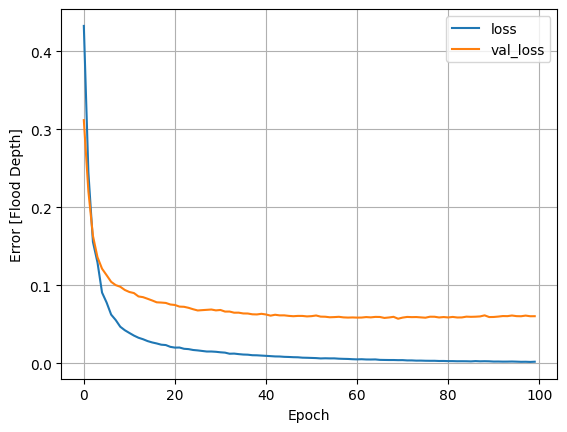

In [ ]:
util.plot_loss(history2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


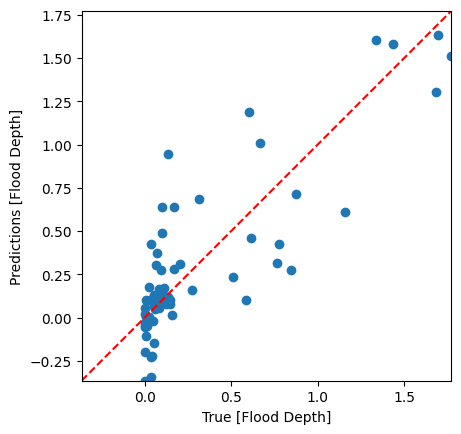

In [ ]:
util.predict(model2, x_test, y_test)